In [1]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

In [3]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [4]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [5]:
model.compile(optimizer='adam',
              loss=loss_fn)

In [6]:
class Landscape:
  def __init__(self, model):
    self.weight_list = []
    self.weight_list.append(self.getWeight1D(model))

  def getWeight1D(self, model):
    weight1d = np.empty(0)
    for layer in model.layers:
      for i in range(len(layer.weights)):
        weight = layer.get_weights()[i]
        weight1d = np.concatenate([weight1d, np.ravel(weight)])
    return weight1d

  def setWeight(self, model, weight1d):
    for layer in model.layers:
      weight_list = []
      for i in range(len(layer.weights)):
        shape = layer.get_weights()[i].shape
        size = layer.get_weights()[i].size
        weight_list.append(weight1d[:size].reshape(shape))
        weight1d = weight1d[size:]
      layer.set_weights(weight_list)

  def appendWeight(self, model):
    self.weight_list.append(self.getWeight1D(model))

  def PCA(self):
    self.weight_list_np = np.array(self.weight_list)
    self.weight_base = self.weight_list_np[-1, :]
    self.weight_list_np = self.weight_list_np-self.weight_base
    self.pca = PCA(n_components=2, svd_solver="randomized")
    self.pca.fit(self.weight_list_np)
  
  def plotPath(self, model, x, y, resolution=30):
    path = self.pca.transform(self.weight_list_np)
    plt.plot(path[:, 0], path[:, 1], color="r")
    x_max = max(np.max(path[:, 0]), -np.min(path[:, 0]))
    y_max = max(np.max(path[:, 1]), -np.min(path[:, 1]))
    ax = np.linspace(-3*x_max, 3*x_max, resolution)
    ay = np.linspace(-3*y_max, 3*y_max, resolution)
    xx, yy = np.meshgrid(ax, ay)
    zz = np.empty((resolution, resolution))
    for i in range(resolution):
      for j in range(resolution):
        weight = self.pca.inverse_transform(np.array([xx[i][j], yy[i][j]]))
        self.setWeight(model, self.weight_base+weight)
        zz[i][j] = model.evaluate(x, y, batch_size=256, verbose=0)
    plt.contourf(xx, yy, np.log(zz), levels=30)
    plt.colorbar()
    plt.xlabel("1st component")
    plt.ylabel("2nd component")
    plt.show()

In [7]:
LS = Landscape(model)

In [8]:
for i in range(5):
  model.fit(x_train, y_train, batch_size=256)
  LS.appendWeight(model)

235/235 [==============================] - 1s 3ms/step - loss: 0.1833


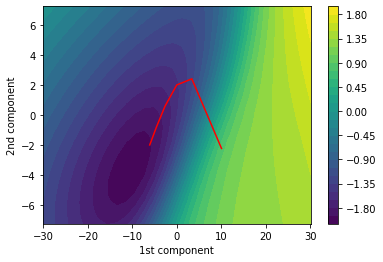

In [9]:
LS.PCA()
LS.plotPath(model, x_test, y_test)